In [ ]:
!pip install earthpy

Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
"""
Python package for Earth Data, 
earthpy.spatial -> Functions to manipulate spatial raster and vector data
earthpy.plot -> functionality around spatial plotting.
"""
import earthpy.plot as ep
import earthpy.spatial as es

#plotting library
import plotly.graph_objects as go
import plotly.express as px

# The dataset is in .mat files, the below statement load the .mat files
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

"""for adding progress bar. It lets you configure and 
display a progress bar with metrics you want to track. """
from tqdm import tqdm

Data is the spectral images of the Pavia University. 

Groud truth is the visualization of the data, where black color representing pixels with no information which will be discarded during the classification process. 

In [ ]:
data = loadmat('/content/drive/MyDrive/PROJECT_GIT/HyperSpectral_Image_Classification/PaviaU.mat')['paviaU']
ground_truth = loadmat('/content/drive/MyDrive/PROJECT_GIT/HyperSpectral_Image_Classification/PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
# returns contiguous flattened array
#(1D-array with all the input-array elements and with the same type as it)
df['class'] = ground_truth.ravel()

Dataset - Pavia University HSI, acquired by the ROSIS sensor during a flight campaign. 
It has 103 spectral bands, containing 610 * 340 pixels, but spectral samples of the image contain no information which is defined as Zero (0). 
Geometric resolution=1.3 meters. 

The groundtruth of the HSI is differentiated into 9 classes.
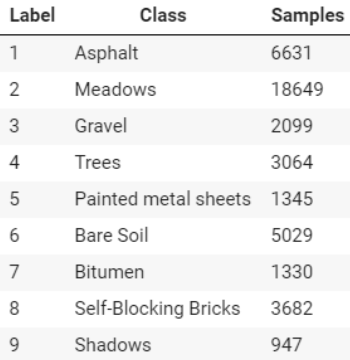

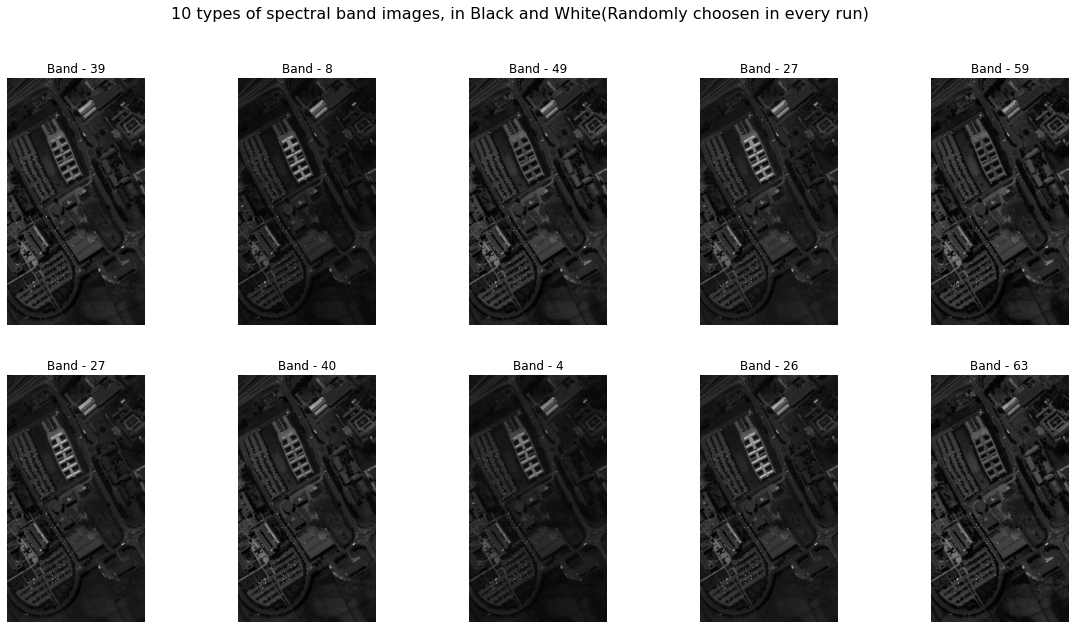

In [ ]:
fig = plt.figure(figsize = (20,10))
ax= fig.subplots(2,5)

for i in range(2):
  for j in range(5):
    c= np.random.randint(103)
    ax[i][j].imshow(data[:,:,c], cmap = 'gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f'Band - {c}') #the spectral band
    c += 1
fig.suptitle("10 types of spectral band images, in Black and White(Randomly choosen in every run)", fontsize = 16)
plt.show()

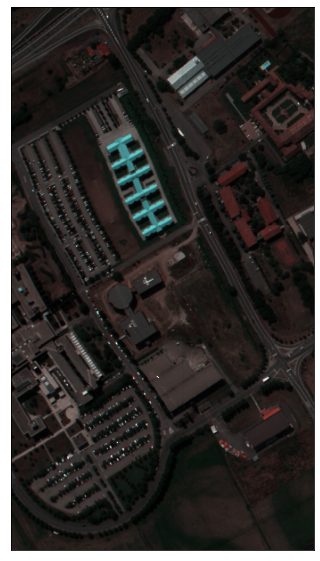

In [ ]:
m_data = np.moveaxis(data, -1, 0)
ep.plot_rgb(m_data, (55, 25, 22), figsize = (15,10))
plt.show()

Ground truth visualization of the HSI

A color bar with 9 different color ranges shown on the right side

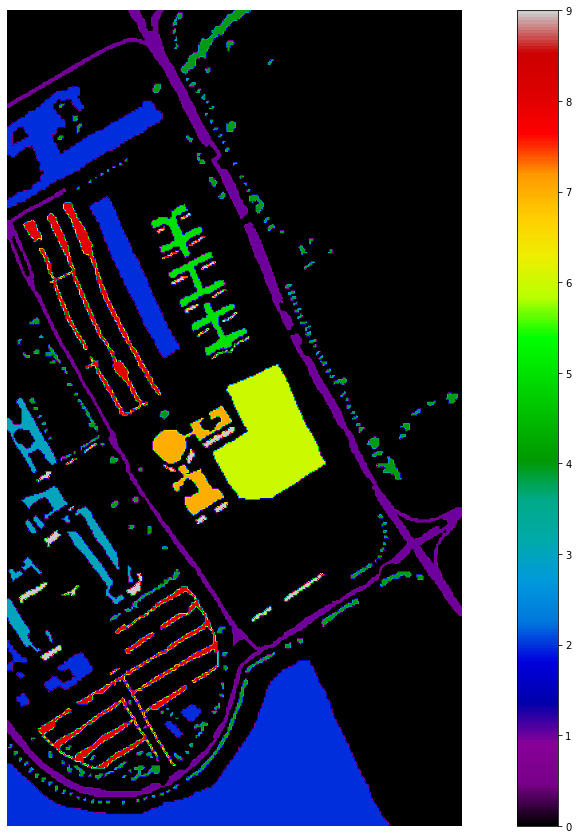

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize = (20,15))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(ground_truth)

In [ ]:
X  = df[df['class'] != 0].iloc[:, :-1].values

y=  tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , num_classes = np.unique(ground_truth).shape[0], dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify=y)

print(f"Train Data: {X_train.shape}\nTest Data: {X_test.shape}")
print(f"\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}")

Train Data: (34220, 103)
Test Data: (8556, 103)

Train Labels: (34220, 10)
Test Labels: (8556, 10)


Model - 
* Starting from 128 units
* 12 dense layers
* For regularization, Dropout rate = 0.2

* Adam Optimizer
* Categorical cross entropy
* Metric - accuracy

In [ ]:
#Initialize model

model = Sequential(name = 'PavU_HSI')

model.add(Input(shape = X_train[0].shape, name = "Input_layer"))
model.add(BatchNormalization(name = 'Batch_Norm'))

#Dense Layers
model.add(Dense(units = 128, activation = 'relu', name = 'Dense_L1'))
model.add(Dense(units = 128, activation = 'relu', name = 'Dense_L2'))
model.add(Dense(units = 128, activation = 'relu', name = 'Dense_L3'))
model.add(Dense(units = 128, activation = 'relu', name = 'Dense_L4'))

#First drop out 
model.add(Dropout(rate = 0.2, name = 'Drop_1'))

# More Dense layers after droping some neurons
model.add(Dense(units = 64, activation = 'relu', name = 'Dense_L5'))
model.add(Dense(units = 64, activation = 'relu', name = 'Dense_L6'))
model.add(Dense(units = 64, activation = 'relu', name = 'Dense_L7'))
model.add(Dense(units = 64, activation = 'relu', name = 'Dense_L8'))

#Second drop out
model.add(Dropout(rate = 0.2, name = 'Drop_2'))

#More Dense layers after second dropout
model.add(Dense(units = 32, activation = 'relu', name = 'Dense_L9'))
model.add(Dense(units = 32, activation = 'relu', name = 'Dense_L10'))
model.add(Dense(units = 32, activation = 'relu', name = 'Dense_L11'))
model.add(Dense(units = 32, activation = 'relu', name = 'Dense_L12'))

#Output layer 
model.add(Dense(units = y_train.shape[1], activation = 'softmax', name = 'Output_layer'))

In [ ]:
model.summary()

Model: "PavU_HSI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm (BatchNormalizat  (None, 103)              412       
 ion)                                                            
                                                                 
 Dense_L1 (Dense)            (None, 128)               13312     
                                                                 
 Dense_L2 (Dense)            (None, 128)               16512     
                                                                 
 Dense_L3 (Dense)            (None, 128)               16512     
                                                                 
 Dense_L4 (Dense)            (None, 128)               16512     
                                                                 
 Drop_1 (Dropout)            (None, 128)               0         
                                                          

| Optimization - ADAM_APPLE

| Early Stopping - when a specific metric that has been monitoring the training has stopped improving, stop the training 
(https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping )

| Model CheckPoint - save a model(its weights) at some interval, so the model/weights can be loaded later to continue the training from the state saved.

It is mainly being used to save the model if suddenly the training stops due to early stopping, as loss function will not be improving, meaning loss would be stopped decreasing. 

(https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint )

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Callback functions
early_stop = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)

#Fitting 
fitItUp = model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), epochs = 50, callbacks = [early_stop, checkpoint])

Epoch 1/50
1061/1070 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.9068
Epoch 1: val_loss improved from inf to 0.15916, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 6s 4ms/step - loss: 0.2500 - accuracy: 0.9067 - val_loss: 0.1592 - val_accuracy: 0.9497
Epoch 2/50
1066/1070 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.9088
Epoch 2: val_loss improved from 0.15916 to 0.15234, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 5s 5ms/step - loss: 0.2435 - accuracy: 0.9087 - val_loss: 0.1523 - val_accuracy: 0.9406
Epoch 3/50
1062/1070 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9110
Epoch 3: val_loss did not improve from 0.15234
1070/1070 [==============================] - 5s 4ms/step - loss: 0.2487 - accuracy: 0.9110 - val_loss: 0.1600 - val_accuracy: 0.9440
Epoch 4/50
1069/1070 [============================>.] - ETA: 0s - loss: 0.23

History of the training and testing events(Loss & Accuracy)
# Visualization

In [ ]:
hist = pd.DataFrame(data = fitItUp.history)
fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values, mode = 'lines+markers', name = 'Training Loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values, mode='lines+markers', name='Training Accuracy' ))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values, mode='lines+markers', name='Test loss'))
fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values, mode='lines+markers', name='Test Accuracy'))
fig.show()

Classification report (precision | recall| f1_score| support)

In [ ]:
pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1. Asphalt', '2. Meadows',              '3. Gravel', 
                      '4. Trees',   '5. Painted metal sheets', '6. Bare Soil', 
                      '7. Bitumen', '8. Self-Blocking Bricks', '9. Shadows']))

268/268 [==============================] - 1s 3ms/step
                         precision    recall  f1-score   support

             1. Asphalt       0.95      0.97      0.96      1304
             2. Meadows       0.99      0.97      0.98      3777
              3. Gravel       0.83      0.82      0.83       421
               4. Trees       0.96      0.97      0.96       605
5. Painted metal sheets       1.00      1.00      1.00       269
           6. Bare Soil       0.93      0.96      0.95       978
             7. Bitumen       0.90      0.85      0.87       282
8. Self-Blocking Bricks       0.87      0.88      0.87       731
             9. Shadows       1.00      1.00      1.00       189

               accuracy                           0.95      8556
              macro avg       0.94      0.94      0.94      8556
           weighted avg       0.95      0.95      0.95      8556



More visualization - heatmap 

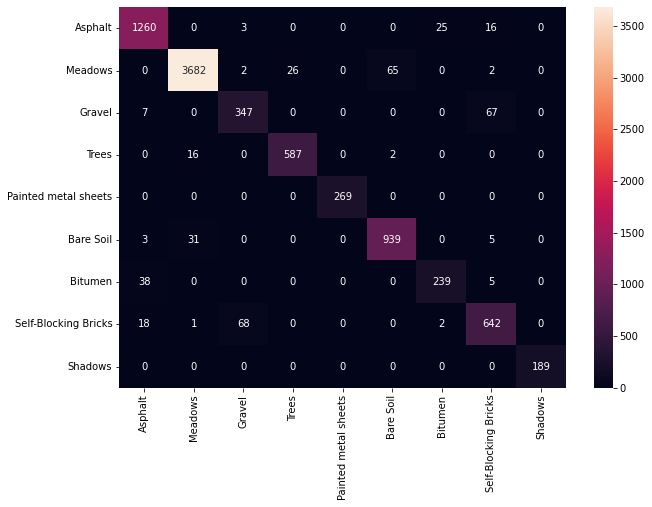

In [ ]:
plt.figure(figsize = (10,7))

classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()